## Load CLIP

In [1]:
import clip
import torch
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
state_dict = torch.load("finetuned_RN50.pt", map_location=device, weights_only=True)
model, preprocess = clip.load("RN50", device=device)

model.load_state_dict(state_dict["CLIP"])

c:\Users\LENOVO\Documents\Github\CS336.O11.KHCL\.venv\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


<All keys matched successfully>

In [3]:
from data_preprocessing import targetpad_transform

input_dim = model.visual.input_resolution # 224
preprocess = targetpad_transform(1.25, input_dim)

## Load dataset

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd

val_dataset_path = Path("splited_fashionIQ") / "val"

features_path = Path("data") / "features"

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11976\1815619613.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
# Load the query image
query_path = val_dataset_path / "245600258X.png"
query_image = preprocess(Image.open(query_path)).unsqueeze(0).to(device)

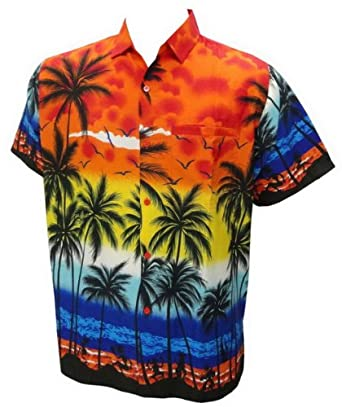

In [10]:
Image.open(query_path)

In [ ]:
# Encode the image using CLIP
with torch.no_grad():
    image_features = model.encode_image(query)

# Convert the features to numpy array
image_features = image_features.cpu().numpy()

# Assume `index` is the Faiss index of your database images
# Search the top 5 most similar images in the database
D, I = index.search(image_features, k=5)

# `I` contains the indices of the top 5 most similar images
print("Indices of the top 5 most similar images:", I[0])
